In [9]:
import sys
sys.path.insert(0, "..")

In [10]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [11]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "DEM"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [12]:
df = get_dataframe(aspect_path, "DEM")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [13]:
def get_mapping(series):
    aspect_raster = access_raster(series['DEM'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

        
def fit_curve(x, y, ax): 
    def test_func(x, a, b):
        return a * x + b
    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0],
                                                method="trf", absolute_sigma=True)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        

    params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0],
                                                method="trf", absolute_sigma=True)

    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, label='Data', s=1)

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")

    ax.legend(loc='best')

    plt.show()
    print(f"Fitted function: {round(params[0]*1e5, 3)}*10^-5 * x + {round(params[1], 3)}")
    
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    np.random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    ax.set_ylabel("HS (m)")
    ax.set_xlabel("Height (m)")
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 0))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values

    plot_map(new_mapping)
    return df

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


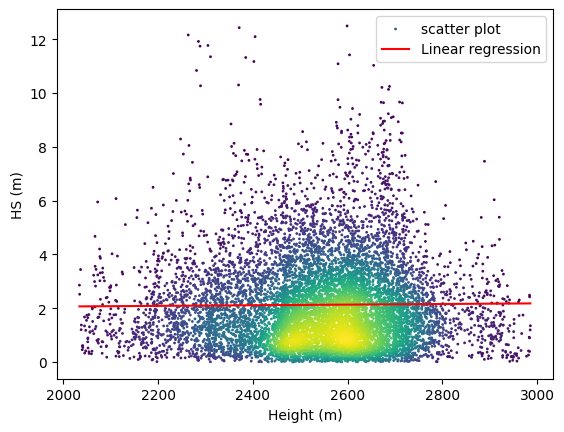

Fitted function: 11.636*10^-5 * x + 1.829
MSE: 2.7168498
R^2: 0.00012642145156860352


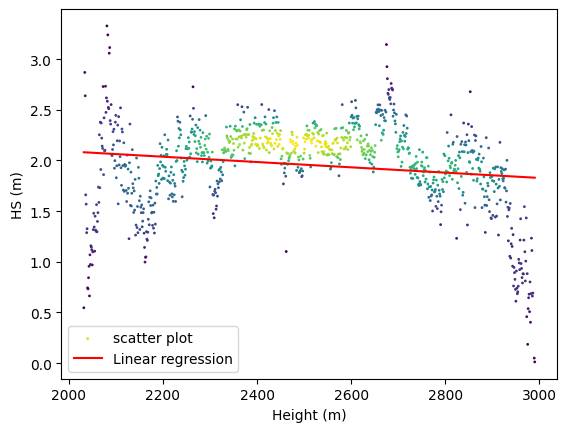

Fitted function: -26.192*10^-5 * x + 2.613
MSE: 0.18179739922248966
R^2: 0.027939710501337922
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


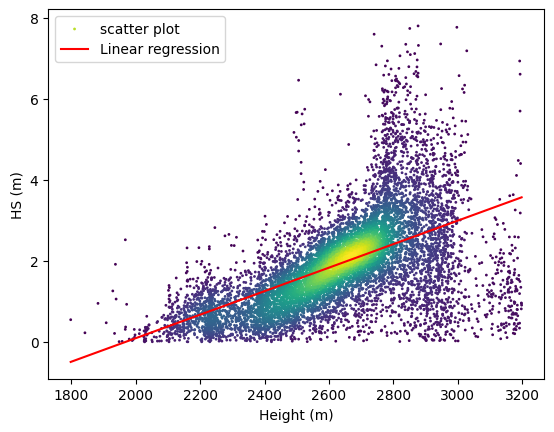

Fitted function: 290.236*10^-5 * x + -5.714
MSE: 0.95446503
R^2: 0.30440205335617065


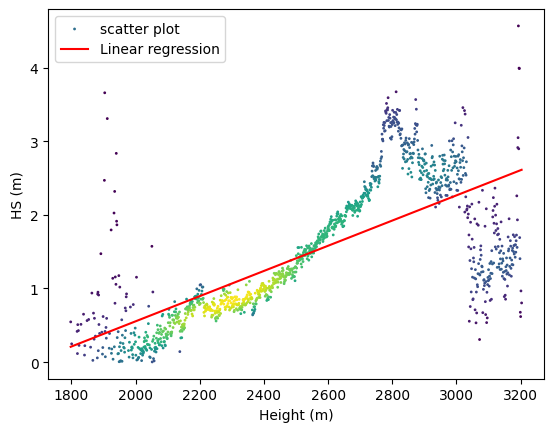

Fitted function: 171.067*10^-5 * x + -2.867
MSE: 0.4236768207255027
R^2: 0.49638963133157854
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


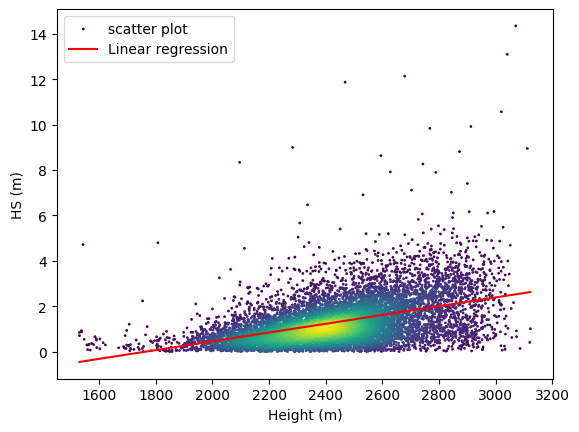

Fitted function: 193.551*10^-5 * x + -3.419
MSE: 0.7784667
R^2: 0.2161480188369751


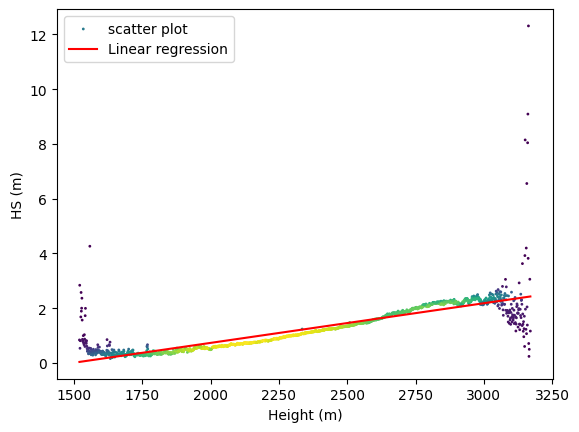

Fitted function: 144.886*10^-5 * x + -2.165
MSE: 0.23944531956018278
R^2: 0.6646494366335929
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


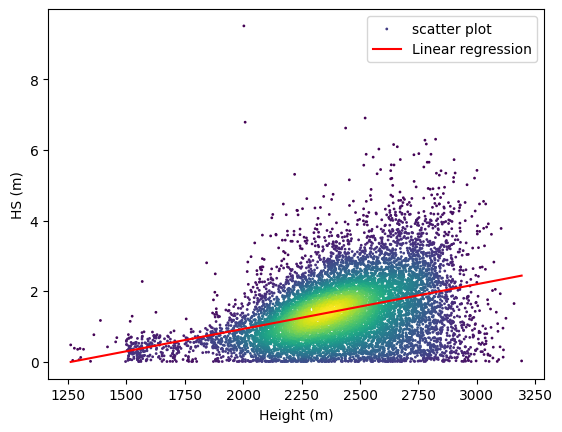

Fitted function: 126.895*10^-5 * x + -1.612
MSE: 0.80516833
R^2: 0.13530898094177246


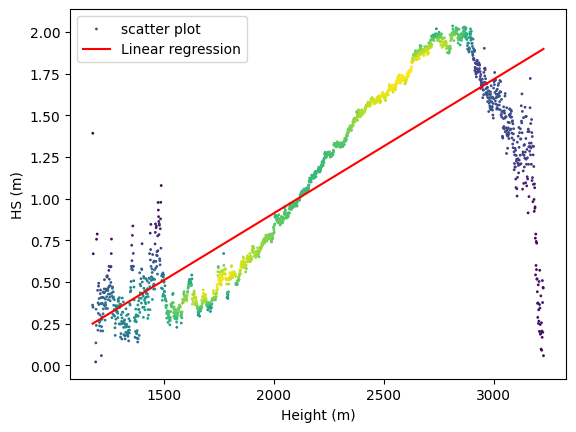

Fitted function: 80.376*10^-5 * x + -0.695
MSE: 0.117800573097866
R^2: 0.6548837443252506
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


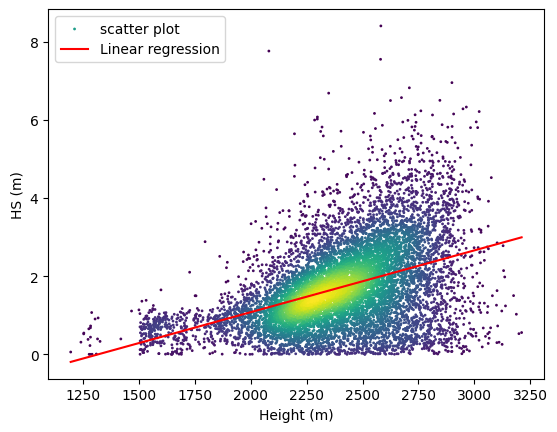

Fitted function: 158.044*10^-5 * x + -2.081
MSE: 0.9455039
R^2: 0.18119925260543823


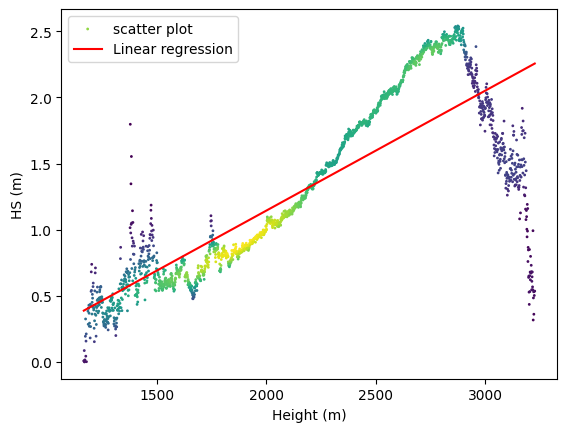

Fitted function: 90.838*10^-5 * x + -0.673
MSE: 0.14664591731679244
R^2: 0.6630054832083427
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


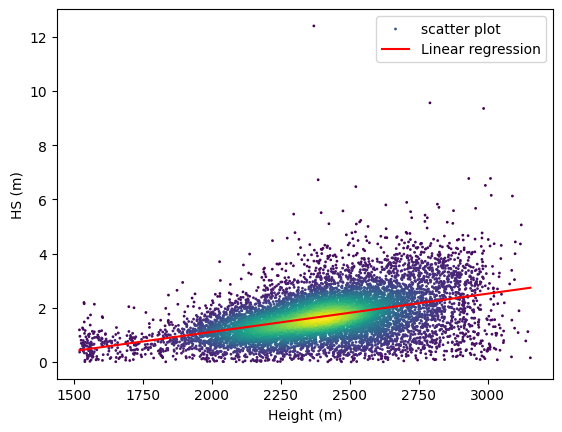

Fitted function: 140.891*10^-5 * x + -1.707
MSE: 0.6069867
R^2: 0.19659674167633057


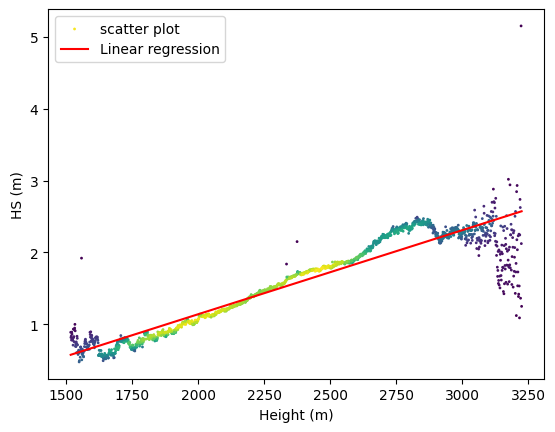

Fitted function: 116.879*10^-5 * x + -1.198
MSE: 0.05004949762937867
R^2: 0.869165211707408
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


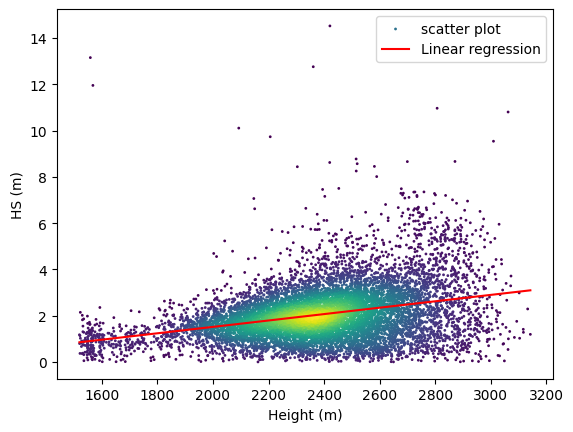

Fitted function: 138.299*10^-5 * x + -1.25
MSE: 1.2275838
R^2: 0.10747796297073364


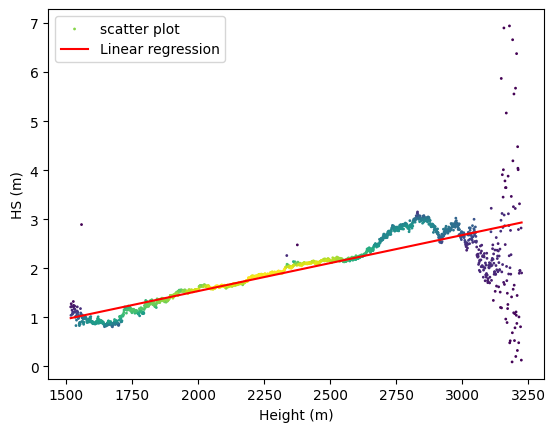

Fitted function: 114.203*10^-5 * x + -0.748
MSE: 0.20071961244239328
R^2: 0.6115543777019408
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


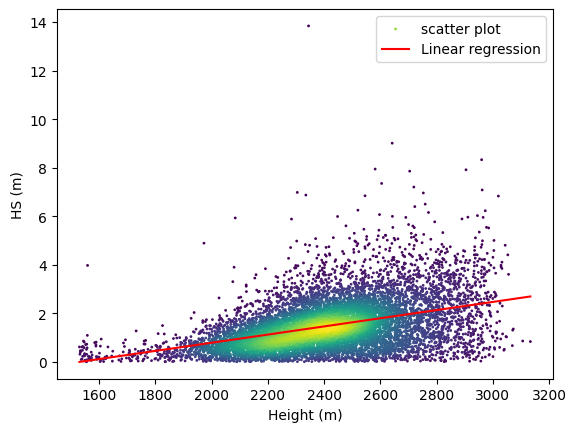

Fitted function: 168.164*10^-5 * x + -2.578
MSE: 0.81570673
R^2: 0.18145185708999634


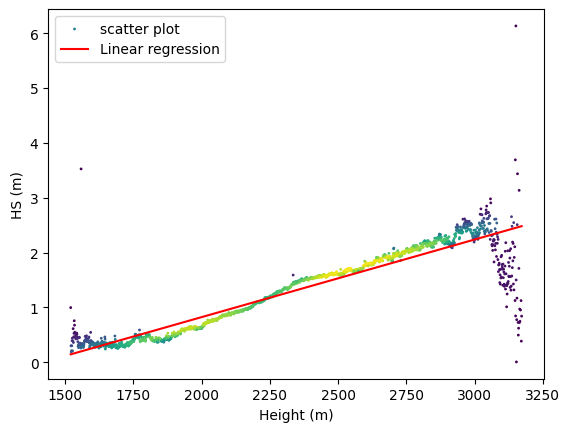

Fitted function: 141.432*10^-5 * x + -2.005
MSE: 0.08737229878183768
R^2: 0.8384155722799094
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


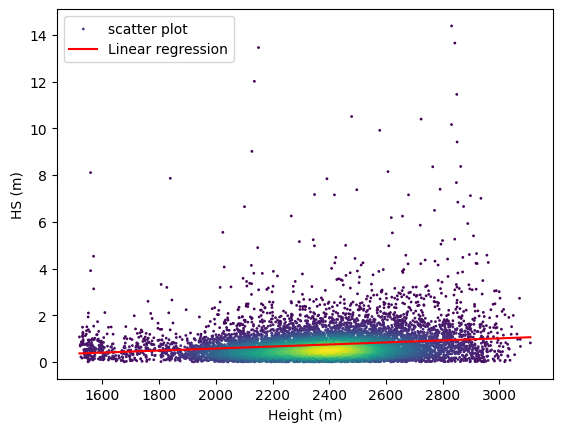

Fitted function: 43.582*10^-5 * x + -0.297
MSE: 0.5572584
R^2: 0.02551168203353882


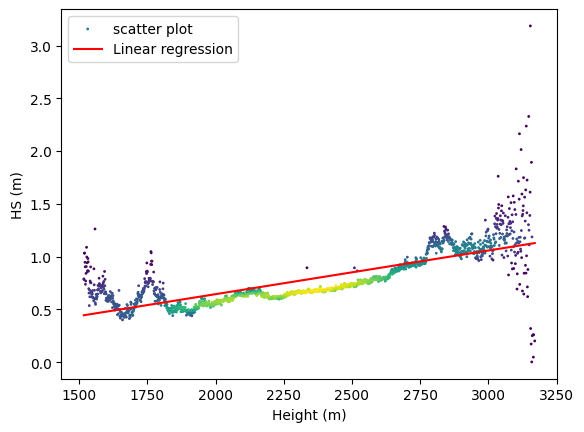

Fitted function: 41.361*10^-5 * x + -0.183
MSE: 0.030724771459071345
R^2: 0.5570117419464591
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


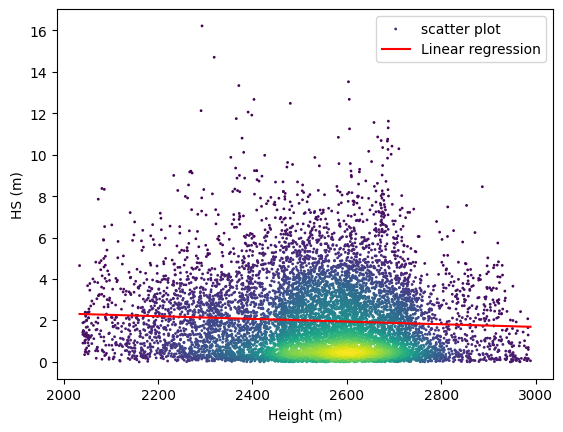

Fitted function: -64.674*10^-5 * x + 3.63
MSE: 3.3999164
R^2: 0.0035899877548217773


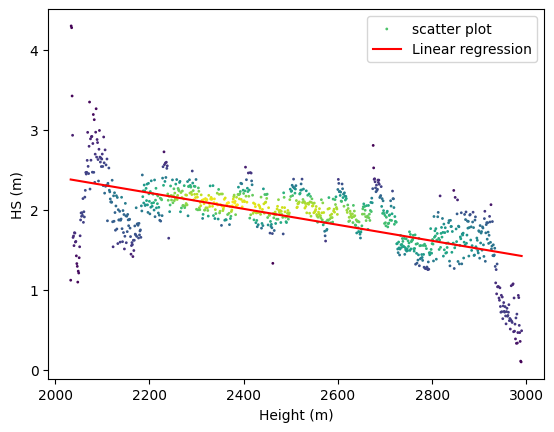

Fitted function: -99.994*10^-5 * x + 4.41
MSE: 0.12660607162235704
R^2: 0.37656402828767976
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


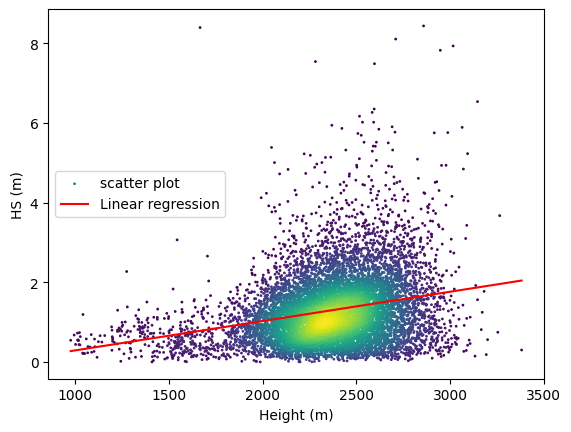

Fitted function: 73.563*10^-5 * x + -0.445
MSE: 0.65816736
R^2: 0.0677306056022644


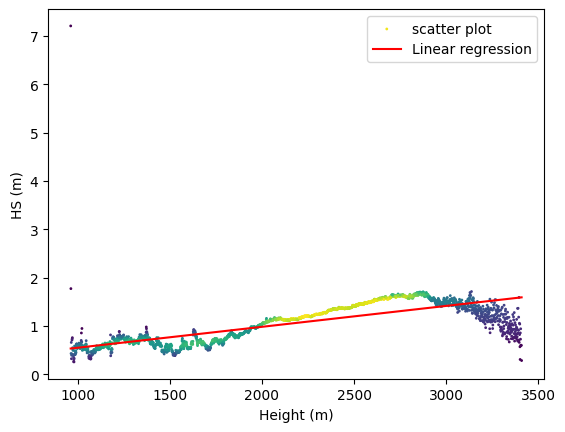

Fitted function: 43.258*10^-5 * x + 0.118
MSE: 0.07328849158198249
R^2: 0.5600540743663065
____________________________________________________________________________________________________ 
 HS_Davos_20180411_2m_epsg2056


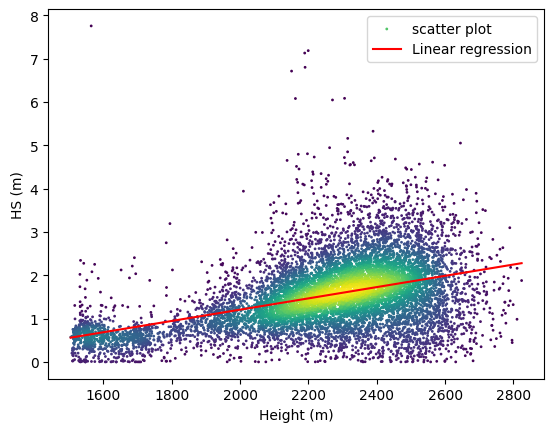

Fitted function: 130.279*10^-5 * x + -1.399
MSE: 0.5015641
R^2: 0.2036879062652588


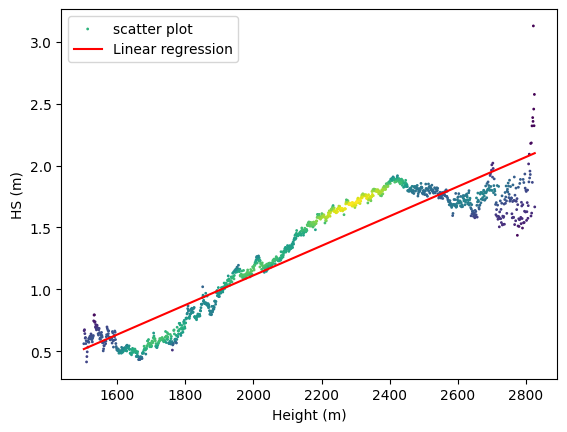

Fitted function: 119.525*10^-5 * x + -1.278
MSE: 0.03647898682489124
R^2: 0.8514038499044407
____________________________________________________________________________________________________ 
 snowmap_20160420_ads_100_extent_maskiert_nosnow0_noausreisser


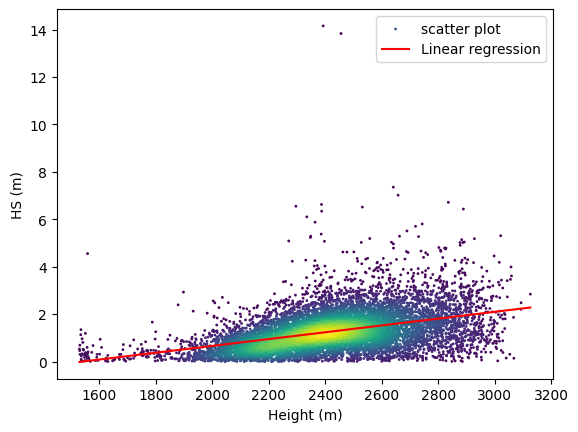

Fitted function: 143.636*10^-5 * x + -2.213
MSE: 0.5515357
R^2: 0.18563717603683472


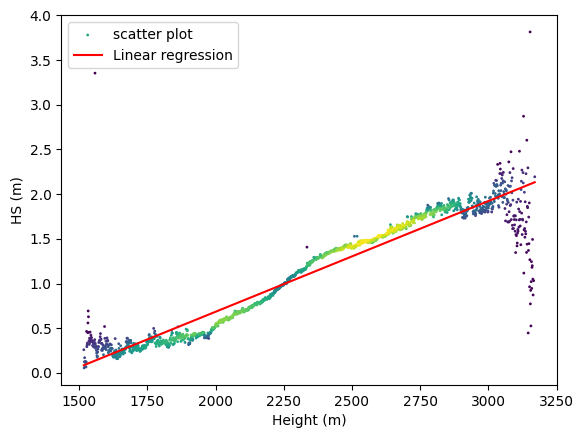

Fitted function: 123.877*10^-5 * x + -1.793
MSE: 0.0421002673864146
R^2: 0.8921230106502314
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220224_2m_epsg2056


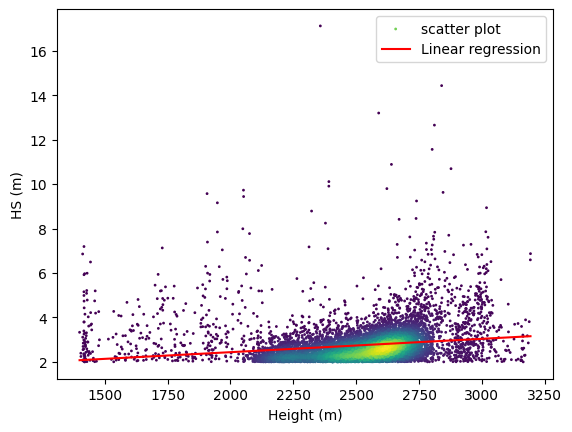

Fitted function: 60.134*10^-5 * x + 1.236
MSE: 0.6058085
R^2: 0.03411364555358887


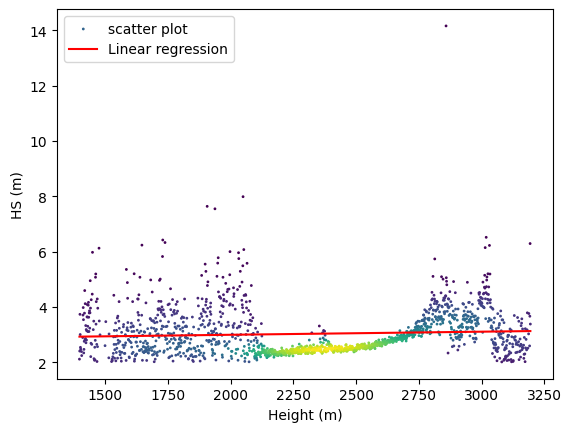

Fitted function: 11.206*10^-5 * x + 2.773
MSE: 0.6858003108113859
R^2: 0.004482368929439651
____________________________________________________________________________________________________ 
 snowmap_2010_ads_80_extent_maskiert_nosnow0_noausreisser


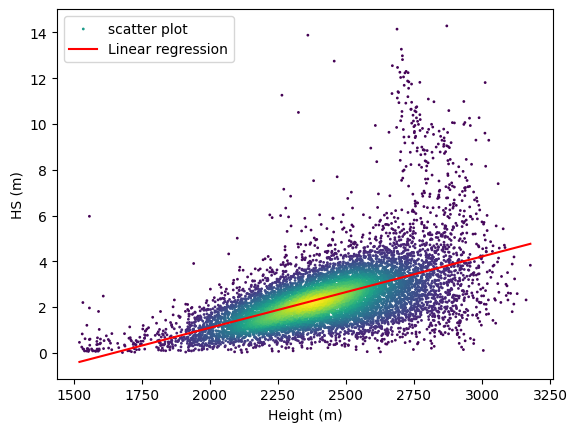

Fitted function: 311.802*10^-5 * x + -5.143
MSE: 1.507381
R^2: 0.292283833026886


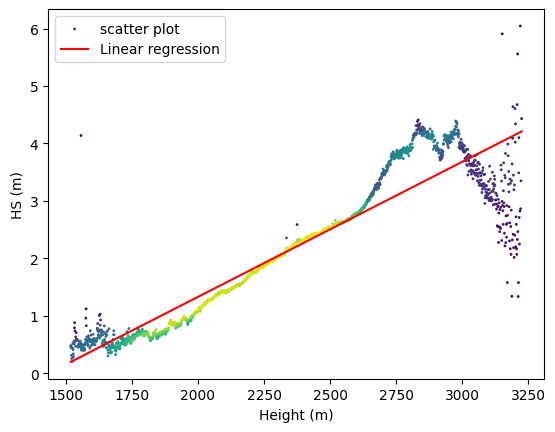

Fitted function: 235.256*10^-5 * x + -3.375
MSE: 0.23735322394752972
R^2: 0.849300313515938


In [14]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)